# Detect Disturbed Trees

This notebook presents a comprehensive analysis aimed at identifying potentially disturbed or sick trees using time series data of spectral bands and vegetation indices. The workflow combines exploratory data analysis, feature engineering, and preparation of a training dataset for a machine learning model.

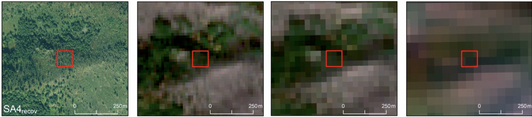

Table of Contents
 1. Setup & Imports
 2. Idea and Approach
 3. Features to detect disturbed trees
 4. Analysis of the significance of the features
 5. Prepare Train Data

## Setup & Imports

In [ ]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.preprocessing import Preprocessing
from utils.visualization_utils.visualization_time_series import (
    plot_timeseries_oneid,
    plot_timeseries_multiple_ids,
)
from utils.correlation_analysis import CorrelationAnalysis
from src.pipelines.processing.processing_steps.detect_disturbed_trees import (
    DetectDisturbedTrees,
)
from utils.constants import spectral_bands, indices

bands_and_indices = spectral_bands + indices

In [ ]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../data/raw/raw_trainset.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

calculateindices = CalculateIndices()
df = calculateindices.run(df)

disturbed_detector = DetectDisturbedTrees()

## Idea and Approach 

*How to identifying Sick Trees (Not Labeled as “Disturbed”)?*

**1. Identify features that can indicate tree disease**

- **Normalization**  
  Performed separately for each species
  - to account for differing value ranges and improve correlation with labels. 
  - Though not a standard ML approach, it gave better results in this case.

- **Yearly Aggregation**  
  Data was averaged per year before feature calculation.  
  - This reduced seasonal noise and highlighted long-term trends.

- **Feature Calculation (per tree ID)**  
  From yearly means, two key features were identified:  
  - **Slope** of yearly means
  - **Standard deviation** of yearly means
  - The difference between first and last year was not useful.

- **Feature Analysis**  
  - Correlations with the label (`is_disturbed`) were calculated.  
  - IDs with high feature values (e.g., large `b11_slope`) were plotted to verify if they indicated disease.  
  - This helped confirm the most informative features.


**2. Train an ML Model to Detect potentially sick Trees**

- **Training Data Preparation**  
  - Use all trees labeled as disturbed (disturbance year ≥ 2017).  
  - Include a sample of likely healthy trees, selected by filtering using features that are highly correlated with disturbance.

- **Model Training**  
  - Train a classifier to distinguish disturbed from healthy trees.

- **Application**  
  - Apply the model to "healthy" trees to identify potential disturbed trees.


## Features to detect disturbed trees

### Generate Features

1. Normalize all columns.
2. Group by id and year, and compute mean values for index & band columns
3. For each id, calculate the yearly standard deviation and slope of each index
4. Add the is_disturbed column to the final DataFrame.

In [ ]:
df_scaled = disturbed_detector.scale_data(df)
# normalization grouped by species because different species can have different ranges

df_yearly = disturbed_detector.get_yearly_data(df_scaled)

df_std = disturbed_detector.get_std(df_yearly)
df_slope = disturbed_detector.get_slope(df_yearly)

df_std_slope = df_std.merge(df_slope, on="id", how="left")
df_std_slope = disturbed_detector.get_label(df, df_std_slope)
df_std_slope

### Correlation between features and disturbance

In [ ]:
corr_analyser = CorrelationAnalysis(df_std_slope)
correlations = corr_analyser.get_correlations_with_target("is_disturbed")
correlations

In [ ]:
corr_analyser.plot_correlations_with_target(correlations, top_n=20)

## Analysis of the significance of the features

In [ ]:
col = "b11"
slope_or_stdv = "slope"
df_std_slope[~df_std_slope["is_disturbed"]].sort_values(
    f"{col}_{slope_or_stdv}", ascending=False
)
# plot timeseries of id's with high slope or std to see if they are actually disturbed

In [ ]:
ids_to_plot = [11876, 23540, 26787, 1759]
plot_timeseries_multiple_ids(df_scaled, ids_to_plot, "b11", df_yearly)

<div class="alert-info">

For different features many examples were plotted, like here for b11_slope:
id with highest b11_slope (and not disturbed )

- id with the 300th highest b11_slope
- id with the 400th highest b11_slope
- id with the 550th highest b11_slope
- the last one is probably not disturbed

</div>

## Prepare Train-Data

Build training data from data with presumably correctly labeled data

In [ ]:
disturbed_df = df_std_slope[df_std_slope["is_disturbed"]].copy()
healthy_df = df_std_slope[~df_std_slope["is_disturbed"]].copy()

In [ ]:
top_features = ["b11_slope", "b5_slope", "b11_std", "gndvi_std"]
healthy_df["combi_top_features"] = healthy_df[top_features].mean(axis=1)
healthy_df.sort_values(by="combi_top_features")

In [ ]:
plot_timeseries_oneid(df_scaled, 4744, "b11", df_yearly)

<div class="alert-info">

- Idea: Healthy df with 10,000 data points that are almost certainly not disturbed
- the four top features must have a low value

- Testing of random samples showed that the first 20,000 rows of healthy_df should not be disturbed trees.

</div>

In [ ]:
healthy_df_sub = (
    healthy_df.sort_values(by="combi_top_features")
    .head(20000)
    .sample(n=10000, random_state=42)
)

# Using .head(10000) slightly worsened model performance, so a random sample of the first 20.000 rows was used instead

train_df = (
    pd.concat([disturbed_df, healthy_df_sub])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("Disturbed:", len(disturbed_df))
print("Healthy (balanced):", len(healthy_df_sub))
print("Training set total:", len(train_df))